# Bach LSTM

This project uses a single layer LSTM deep learning network to write music in Bach's style. The network is trained on Bach fugues, and then the network outputs a series of musical notes. This is a similar process to text generation using an LSTM network. MIDI notes are treated as a series of words for training the network. The network uses the previous 100 MIDI notes to predict the next MIDI note.

The output was then imported in a DAW (Digital Audio Workstation) where everything was forced into Cmajor. You can hear the results [at this youtube link](https://www.youtube.com/watch?v=uh3myqiX7es&t=2s).

In [34]:
import requests
import copy
from music21 import *
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

# Download Midi Files from the BachCentral Website

This code downloads MIDI files from the Bach Central website. You can uncomment this code to download the files or download the files manually.

In [65]:
# Uncomment this code to 
# download the midi files from the bachcentral website

# for i in range(1,25):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkI/{}'.format(file_name)
#     r = requests.get(url)

#     with open(file_name, 'wb') as f:
#         f.write(r.content)

# for i in range(1,13):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkIIx/{}'.format(file_name)
#     r = requests.get(url)
#     file_name = 'Fugue{}_wtcii.mid'.format(i)
#     with open(file_name, 'wb') as f:
#         f.write(r.content)

# Functions for Data Preparation and Cleaning

In [66]:
def clean_zero_durations(midi_data):
    """
    Cleans midi data with zero length values to 0.125 for a quarter note
    
    args:
        midi_data - a stream of midi data
        
    returns:
        midi_data - a stream of midi data with the zero length values fixed
    
    """
    for stream in range(len(midi_data)):
        for element in range(len(midi_data[stream])):
            current_element = midi_data[stream][element]
            if isinstance(current_element, note.Note) or isinstance(current_element, chord.Chord) or isinstance(current_element, note.Rest):
                if current_element.duration.quarterLength == 0:
                    midi_data[stream][element].quarterLength = 0.125
    return midi_data

def print_zero_midi_data(midi_data):
    """
    Prints notes with zero length
    
    
    args:
        midi_data - a stream of midi data
        
    returns:
        None
        
    """
    for stream in range(len(midi)):
        for element in range(len(midi[stream])):
            current_element = midi[stream][element]
            if current_element.duration.quarterLength == 0:
                print(midi[stream][element].quarterLength, current_element)

def print_midi_data(midi_data):
    """
    Prints all elements in a MIDI stream for data exploration
    
    args:
        midi_data - a stream of midi data
        
    returns:
        None
    """
    
    for stream in range(len(midi_data)):
        current_stream = midi_data[stream].notesAndRests
        for element in range(len(current_stream)):
            current_element = current_stream[element]
            print(current_element.duration.type, current_element, current_element.duration.quarterLength)

In [67]:
def get_notes(midi_data):
    """
    cleans midi data and appends each note to a list in the order in which appears in the fugue
    
    
    args:
        midi_data - song with midi data
        
        
    returns:
        features (list) - contains a list of notes, chords, and rests from the midi file in order
        
    TODO: LSTM for music applications are said to work better when all songs are in the same key,
            so translating all fugues so that they start in C might give better results
    """
    
    features = []

    # from music21 library, converts midi notes into chords
    # note that this method is not perfect. For better results, could be worth doing this manually
    midi_data = midi_data.chordify() 
    
    # iterate through the notes in the midi data and append to the list
    for element in midi_data.notesAndRests:
        if isinstance(element, note.Rest):
            features.append('{}%{}'.format(element.duration.quarterLength, element.name))
        elif isinstance(element, note.Note):
            features.append('{}%{}'.format(element.duration.quarterLength, element.namewithOctave))            
        elif isinstance(element, chord.Chord):
            current_chord = [str(element.duration.quarterLength)]
            for chord_note in element:
                # only appends a chord if the chord is played for the first time
                # in other words, if a chord note is from a tie (held over), then the chord is not
                # actually played but sustained from a previous chord, so it should not be counted as a new note
                if (chord_note.tie) and (chord_note.tie.type == 'start') or not(chord_note.tie):
                    current_chord.append(chord_note.nameWithOctave)
            if len(current_chord) == 1: # handles case where chor dis actually a rest
                current_chord.append('rest')
            features.append('%'.join(current_chord))
        
    return features

In [68]:
def load_data():
    """
    Loads all midi data as a list of Midi notes. Prints out file names that could not be read
    
    args:
        None
    
    returns
        notes_data - list of midi file data
        
    TODO: dilineate between the start and end of a MIDI file so that training data does not overlap between fugues
    """
    
    notes_data = []
    cwd = os.getcwd()
    for path in Path(cwd).glob('**/*.mid'):
        # because path is object not string
        file = str(path)
        try:
            midi = converter.parse(file)
            midi = clean_zero_durations(midi)
            notes = get_notes(midi)
            notes_data.extend(notes)
        except: # print names of files that were not read successfully
            print(file)
    return notes_data

# Prepare and Explore Data 

In [69]:
notes_data = load_data() # load data and print out files that could not be read successfully

/Users/Andrew/Documents/GitHub/bach-lstm/Fugue10_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue11_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue12.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue12_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue19.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue1_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue2_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue3_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue4_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue5_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue6.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue6_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue7_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue8_wtcii.mid
/Users/Andrew/Documents/GitHub/bach-lstm/Fugue9_wtcii.mid


In [70]:
len(notes_data)

16313

Text(0.5,1,'Histogram of number of times a note combination appears')

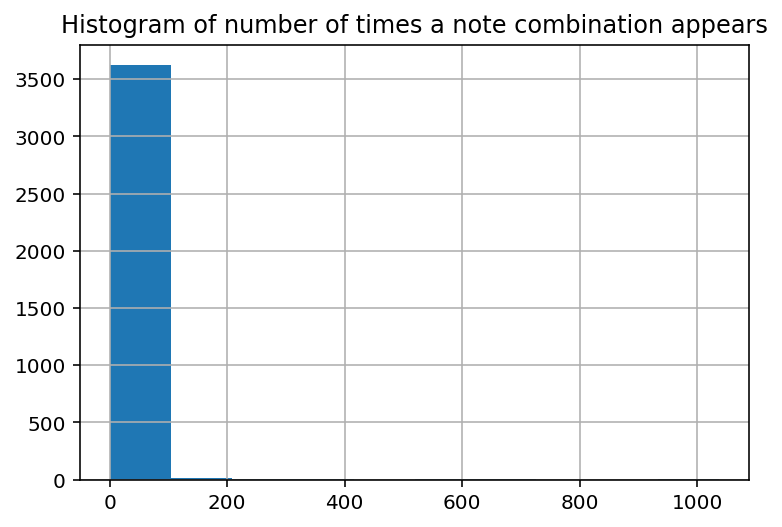

In [74]:
df = pd.DataFrame(notes_data)
df.columns = ['notes']
df['count'] = df.groupby('notes')['notes'].transform('count')

# histogram shows that most note combinations appear fewer than 100 times
df.drop_duplicates()['count'].hist()
plt.title('Histogram of number of times a note combination appears')

# Further Preparation: Convert Note Names to Integers

In [75]:
# create mapping of unique chars to integers
chars = sorted(list(set(notes_data)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

# the vocabulary of 3746 different notes is relatively large
# this is because Bach's music sometimes contains signal notes, simultaneous notes, notes of different lengths, etc
# TODO: could be interesting to simplify the vocabulary by using only one note length
n_chars = len(notes_data)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  16313
Total Vocab:  3643


In [76]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 50 # can change the sequence length
dataX = []
dataY = []

# sliding window over the notes data so that features have 100 notes and response the note that follows
for i in range(0, n_chars - seq_length, 1):
    seq_in = notes_data[i:i + seq_length]
    seq_out = notes_data[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in]) # converts characters to integers using mapping
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

Total Patterns:  16263


# Define and Fit the Model

In [81]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# define the checkpoint
filepath=str(datetime.datetime.now()) + "-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [82]:
# fit the model
n_epochs = 50 # can change the number of epochs

model.fit(X, y, epochs=n_epochs, batch_size=32, callbacks=callbacks_list)

Epoch 1/50
16263/16263 [==============================] - 96s 6ms/step - loss: 6.7860

Epoch 00001: loss improved from inf to 6.78600, saving model to 2018-11-09 16:45:04.528977-01-6.7860.hdf5
Epoch 2/50
16263/16263 [==============================] - 94s 6ms/step - loss: 6.3646

Epoch 00002: loss improved from 6.78600 to 6.36462, saving model to 2018-11-09 16:45:04.528977-02-6.3646.hdf5
Epoch 3/50
16263/16263 [==============================] - 111s 7ms/step - loss: 6.1548

Epoch 00003: loss improved from 6.36462 to 6.15477, saving model to 2018-11-09 16:45:04.528977-03-6.1548.hdf5
Epoch 4/50
16263/16263 [==============================] - 106s 7ms/step - loss: 6.0305

Epoch 00004: loss improved from 6.15477 to 6.03053, saving model to 2018-11-09 16:45:04.528977-04-6.0305.hdf5
Epoch 5/50
16263/16263 [==============================] - 112s 7ms/step - loss: 5.9174

Epoch 00005: loss improved from 6.03053 to 5.91744, saving model to 2018-11-09 16:45:04.528977-05-5.9174.hdf5
Epoch 6/50
16263

Epoch 43/50
16263/16263 [==============================] - 110s 7ms/step - loss: 1.2399

Epoch 00043: loss improved from 1.27221 to 1.23994, saving model to 2018-11-09 16:45:04.528977-43-1.2399.hdf5
Epoch 44/50
16263/16263 [==============================] - 146s 9ms/step - loss: 1.1791

Epoch 00044: loss improved from 1.23994 to 1.17908, saving model to 2018-11-09 16:45:04.528977-44-1.1791.hdf5
Epoch 45/50
16263/16263 [==============================] - 129s 8ms/step - loss: 1.1441

Epoch 00045: loss improved from 1.17908 to 1.14409, saving model to 2018-11-09 16:45:04.528977-45-1.1441.hdf5
Epoch 46/50
16263/16263 [==============================] - 128s 8ms/step - loss: 1.1183

Epoch 00046: loss improved from 1.14409 to 1.11826, saving model to 2018-11-09 16:45:04.528977-46-1.1183.hdf5
Epoch 47/50
16263/16263 [==============================] - 120s 7ms/step - loss: 1.0941

Epoch 00047: loss improved from 1.11826 to 1.09412, saving model to 2018-11-09 16:45:04.528977-47-1.0941.hdf5
Epoch

In [86]:
# load the network weights
filename = "2018-11-09-16:45:04.528977-50-0.9791.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Create New Music

In [118]:
int_to_char = dict((i, c) for i, c in enumerate(chars)) # dictionary mapping integer to character

note_sequence = []

# pick a random seed to start the predictions
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start] #  100 note sequence to start with
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab) # normalization
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    note_sequence.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" 0.5%G#2%E4%B40.5%F#2%F#4%A40.5%C#4%E4%A40.5%D3%B40.5%B2%F#3%A40.5%F3%G#3%C#40.5%B30.5%F#3%A3%F#40.5%F#3%E-40.5%F3%C#50.5%F3%G#4%C#50.5%C#3%C#50.5%B40.5%D50.5%D50.5%D50.5%C#4%E40.5%B40.5%B3%E-40.5%G#3%B40.5%A3%C#50.5%G#3%B40.5%E3%G#40.5%C#3%C#50.5%A4%E50.5%G#3%B4%D50.5%G#3%B40.5%rest0.5%C#4%E40.5%rest0.5%rest0.5%E4%G#40.5%G#31.0%C#30.5%E40.5%F#2%A4%F#50.5%E-50.5%C#5%E50.5%F#3%B-40.5%E-50.5%F#3%B40.5%G3%B40.5%E3%B-40.5%F#3%B-40.5%C#3%E50.5%C#3%E50.5%G#3%E50.5%C#3%E50.5%E-3%F#50.5%B4 "

Done.


In [119]:
note_sequence # outputs the sequences of notes produced by the model

['0.5%G#3%E5',
 '0.5%E3%C#5%G#5',
 '0.5%A3%F#5',
 '0.5%G#3%E5',
 '0.5%A3%G#5',
 '0.5%B2%B4%E-5',
 '0.5%C#3%E5',
 '0.5%A3%G#5',
 '0.5%C#3%G#4',
 '0.5%C#2',
 '0.5%C#3%F5',
 '0.5%C3%E-5',
 '0.5%C#3%F5',
 '0.5%E3%B-4%G5',
 '0.5%G#3%B4',
 '0.5%C#3%C#5',
 '0.5%B4',
 '0.5%G#2%F#5',
 '0.5%B2%D4%F#4',
 '0.5%E3%G#5',
 '0.5%C#4%E4',
 '0.5%E4',
 '0.5%C4%F#4',
 '0.5%F#3',
 '0.5%F#3',
 '0.5%F#3',
 '0.5%F#5',
 '0.5%F#3',
 '0.5%B3%B4',
 '0.5%E-4',
 '0.5%F3%C#4%G#4',
 '0.5%F#3',
 '0.5%B-3%C#5',
 '0.5%A3%F#4%F#5',
 '0.5%F#3%A5',
 '0.5%F#5',
 '0.5%A2%C#5',
 '0.5%B-3%C#5',
 '0.5%A3%F#4',
 '0.5%C#3%C#4%G#4',
 '0.5%B3',
 '0.5%C#2%B3%F4',
 '0.5%D5',
 '0.5%G#3%B4',
 '0.5%B4',
 '0.5%G#3%E5',
 '0.5%C#5',
 '0.5%F#3%A4%E-5',
 '0.5%F#3%A4%E-5',
 '0.5%D5',
 '0.5%B4',
 '0.5%B3%D4',
 '0.5%F#3%E5',
 '0.5%F#3',
 '0.5%F#3',
 '0.5%C#3%G#4',
 '0.5%C#3',
 '0.5%C#3',
 '0.5%G#3%B4',
 '0.5%G#3%B4',
 '0.5%F#3%E-4',
 '0.5%A3%F#4%F#5',
 '0.5%C#4%G#4%E5',
 '0.5%C#5',
 '0.5%F#4',
 '0.5%rest',
 '0.5%rest',
 '0.5%rest',
 '0.5%A3%F#4

# Convert Results to a MIDI file

In [122]:
def from_string_to_music(note_sequence, file_name='midi_file.md'):
    """
    Takes a sequence of notes and converts it to a midi file
    
    args:
        note_sequence - sequence of midi notes outputted from the LSTM model
        file_name - name of file for output
    
    returns:
        midi_stream - midi sequence
        
    """
    
    midi_stream = stream.Stream()
    for entry in note_sequence:
        if entry == 'begin' or entry == 'end':
            continue

        current_notes = entry.split('%')
        duration = float(eval(current_notes[0]))

        if current_notes[1] == 'rest':
            midi_stream.append(note.Rest(quarterLength=duration))
        else:
            chord_notes = []
            for entry in current_notes[1:]:
                chord_notes.append(note.Note(quarterLength=duration, nameWithOctave=entry))
            midi_stream.append(chord.Chord(chord_notes))

    midi_stream.write('midi', fp=file_name)

    return midi_stream

In [123]:
# create a MIDI file
midi_stream = from_string_to_music(note_sequence, 'try_two.mid')

# show the results
for entry in midi_stream.notesAndRests:
    print(entry)

<music21.chord.Chord G#3 E5>
<music21.chord.Chord E3 C#5 G#5>
<music21.chord.Chord A3 F#5>
<music21.chord.Chord G#3 E5>
<music21.chord.Chord A3 G#5>
<music21.chord.Chord B2 B4 E-5>
<music21.chord.Chord C#3 E5>
<music21.chord.Chord A3 G#5>
<music21.chord.Chord C#3 G#4>
<music21.chord.Chord C#2>
<music21.chord.Chord C#3 F5>
<music21.chord.Chord C3 E-5>
<music21.chord.Chord C#3 F5>
<music21.chord.Chord E3 B-4 G5>
<music21.chord.Chord G#3 B4>
<music21.chord.Chord C#3 C#5>
<music21.chord.Chord B4>
<music21.chord.Chord G#2 F#5>
<music21.chord.Chord B2 D4 F#4>
<music21.chord.Chord E3 G#5>
<music21.chord.Chord C#4 E4>
<music21.chord.Chord E4>
<music21.chord.Chord C4 F#4>
<music21.chord.Chord F#3>
<music21.chord.Chord F#3>
<music21.chord.Chord F#3>
<music21.chord.Chord F#5>
<music21.chord.Chord F#3>
<music21.chord.Chord B3 B4>
<music21.chord.Chord E-4>
<music21.chord.Chord F3 C#4 G#4>
<music21.chord.Chord F#3>
<music21.chord.Chord B-3 C#5>
<music21.chord.Chord A3 F#4 F#5>
<music21.chord.Chord F